In [191]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

def load_ml100k():
    # Load dataset
    df = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
    df = df.drop(columns=['timestamp'])

    # Convert to numpy arrays
    user_id = df['user_id'].values - 1  # Make user_id 0-indexed
    item_id = df['item_id'].values - 1  # Make item_id 0-indexed
    rating = df['rating'].values

    # Split into train/test
    user_id_train, user_id_test, item_id_train, item_id_test, y_train, y_test = train_test_split(
        user_id, item_id, rating, test_size=0.2, random_state=42
    )

    user_id_train = torch.tensor(user_id_train, dtype=torch.long)
    item_id_train = torch.tensor(item_id_train, dtype=torch.long)
    y_train = torch.tensor(y_train - 1, dtype=torch.long)

    user_id_test = torch.tensor(user_id_test, dtype=torch.long)
    item_id_test = torch.tensor(item_id_test, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    return (user_id_train, item_id_train, y_train), (user_id_test, item_id_test, y_test)

In [192]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class ClassificationModel(nn.Module):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()
        self.user_embedding = nn.Embedding(max_user_id + 1, embedding_size)
        self.item_embedding = nn.Embedding(max_item_id + 1, embedding_size)

        self.fc1 = nn.Linear(embedding_size * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(0.2)
        self.output = nn.Linear(32, 5)

    def forward(self, inputs):
        user, item = inputs
        u_emb = self.user_embedding(user)
        i_emb = self.item_embedding(item)
        x = torch.cat([u_emb, i_emb], dim=1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.output(x)
        return F.softmax(x, dim=1)

In [193]:
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter

def train_and_evaluate(use_custom_loss=True):

    (user_id_train, item_id_train, y_train), (user_id_test, item_id_test, y_test) = load_ml100k()

    max_user_id = max(user_id_train.max(), user_id_test.max()).item()
    max_item_id = max(item_id_train.max(), item_id_test.max()).item()

    dataset = TensorDataset(user_id_train, item_id_train, y_train)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)
    test_loader = DataLoader(TensorDataset(user_id_test, item_id_test, y_test), batch_size=64)

    model = ClassificationModel(16, max_user_id, max_item_id)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Compute class weights
    counts = Counter(y_train.tolist())
    weights = torch.tensor([1.0 / math.sqrt(counts[i]) for i in range(5)], dtype=torch.float)
    reg_lambda=1e-4

    criterion = nn.CrossEntropyLoss(weight=weights) if not use_custom_loss else None

    train_losses, val_losses = [], []
    for epoch in range(20):
        model.train()
        total_loss = 0
        for user, item, rating in train_loader:
            optimizer.zero_grad()
            output = model((user, item))
            if use_custom_loss:
                loss = custom_loss(output, rating, weights, model, reg_lambda)
            else:
                loss = criterion(output, rating)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for user, item, rating in val_loader:
                output = model((user, item))
                if use_custom_loss:
                    loss = custom_loss(output, rating, weights, model, reg_lambda)
                else:
                    loss = criterion(output, rating)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

    # Plot
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"Training and Validation Loss for {'Custom Loss' if use_custom_loss else 'Cross Entropy'}")
    plt.show()

    # Evaluation
    def get_predictions(loader):
        preds, labels = [], []
        with torch.no_grad():
            for user, item, rating in loader:
                output = model((user, item))
                pred = output.argmax(dim=1) + 1
                preds.extend(pred.tolist())
                labels.extend((rating + 1).tolist())
        return np.array(preds), np.array(labels)

    train_preds, train_labels = get_predictions(DataLoader(dataset, batch_size=64))
    test_preds, test_labels = get_predictions(test_loader)

    print("Train MAE:", manual_mae(train_labels, train_preds))
    print("Train MSE:", manual_mse(train_labels, train_preds))
    print("Test MAE:", manual_mae(test_labels, test_preds))
    print("Test MSE:", manual_mse(test_labels, test_preds))



In [194]:
# Custom weighted loss with regularization
def custom_loss(outputs, targets, weights, model, reg_lambda):
    # ce_loss = F.cross_entropy(outputs, targets, weight=weights)
    # reg_term = sum(torch.norm(param, p=2) for name, param in model.named_parameters() if "embedding" in name)
    # return ce_loss + reg_lambda * reg_term
    batch_size = outputs.size(0)
    log_probs = torch.log(probs + 1e-8)  # avoid log(0)
    class_weights = weights[targets]     # shape: [batch_size]
    loss = -class_weights * log_probs[range(batch_size), targets]
    ce_loss = loss.mean()

    # L2 regularization on embeddings
    reg_term = sum(torch.norm(param, p=2) for name, param in model.named_parameters() if "embedding" in name)
    
    return ce_loss + reg_lambda * reg_term

In [195]:
# MAE, MSE Manual calculation
def manual_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def manual_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

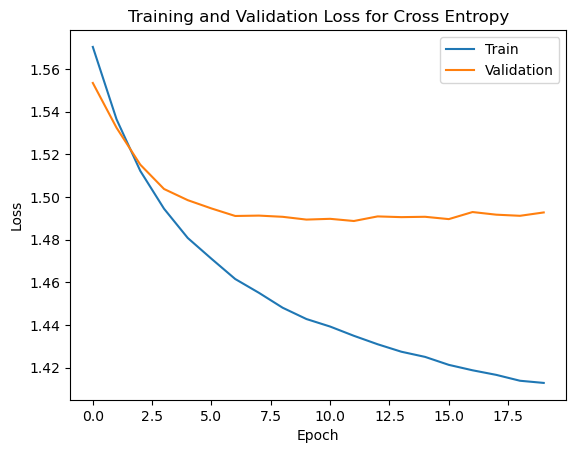

Train MAE: 0.6975375
Train MSE: 1.2147375
Test MAE: 1.117
Test MSE: 2.0101


NameError: name 'probs' is not defined

In [196]:
# Run training
train_and_evaluate(use_custom_loss=False)
train_and_evaluate(use_custom_loss=True)